In [1]:
import torch
import numpy as np
from hsvi import Hierarchy_SVI

In [2]:
from torch import nn
from torch.distributions import Normal

In [3]:
from torch.utils.data import Dataset,Subset
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda,Compose
from torch.utils.data import DataLoader

In [4]:
from utils.train_util import plot

In [5]:
class VAE(nn.Module):
    
    def __init__(self,encoder_shape,decoder_shape,learning_rate=0.001,ac_fn=nn.ReLU) -> None:
        super(VAE, self).__init__()
        self.encoder_shape = encoder_shape
        self.decoder_shape = decoder_shape
        self.ac_fn = ac_fn
        self.fc,self.fc_mu,self.fc_sigma = self.encoder()
        self.dc = self.decoder()
        
    def encoder(self):
        modules = []
        shape = self.encoder_shape
        for i in range(len(shape)-1): 
            d1 = shape[i]
            d2 = shape[i+1]
            fc = nn.Linear(d1,d2,bias=True)
            if i != len(shape)-2:
                modules.append(nn.Sequential(fc,self.ac_fn()))
                
            else:
                h = nn.Sequential(*modules)
                fc_mu = nn.Sequential(h,fc)
                fc_sigma = nn.Sequential(h, nn.Linear(d1,d2,bias=True),nn.Softplus())
                
        
        return h, fc_mu, fc_sigma
    
    
    def decoder(self):
        modules = []
        shape = self.decoder_shape
        for i in range(len(shape)-1): 
            d1 = shape[i]
            d2 = shape[i+1]
            fc = nn.Linear(d1,d2,bias=True)
            if i != len(shape)-2:
                modules.append(nn.Sequential(fc,self.ac_fn()))
                
            else:
                modules.append(nn.Sequential(fc,nn.Sigmoid()))
        h = nn.Sequential(*modules)      
        
        return h
 
    def ec(self,x):
        mu,sigma = self.fc_mu(x), self.fc_sigma(x)
        z = Normal(mu,sigma)
        return z
    
    def forward(self,x):
        z = self.ec(x)
        tx = self.dc(z.rsample())  ### here z.rsample using the reparameterization trick for SVI
        return tx
        

In [6]:
def config_inference(model,TRAIN_SIZE,vi_type='KLqp',learning_rate=0.001,scale=1.,shrink=1.):
    
    
    ### config variational inference ###
    inference = Hierarchy_SVI(vi_types={'global':vi_type},var_dict={'global':model.parameters()},learning_rate={'global':0.001},train_size=TRAIN_SIZE*shrink,scale={'global':{}})        


    return inference

In [7]:
train_size = 10000
test_size = 1000
batch_size = 128
epoch = 100
encoder_shape = [256,128]
decoder_shape = [128,256]
noise_std = 0.01
use_cuda = False

In [8]:
device = torch.device('cuda' if use_cuda else 'cpu')

In [9]:
X_TRAIN = datasets.FashionMNIST(
    root="/home/yu/gits/data/fashion/",
    train=True,
    download=False,
    transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))])
)
indices = torch.arange(train_size)
X_TRAIN = Subset(X_TRAIN, indices)

In [10]:
train_dataloader = DataLoader(X_TRAIN, batch_size=batch_size, shuffle=True,num_workers=8)

In [11]:
### config net shape ###
d_dim = 784
encoder_shape = [d_dim]+encoder_shape
decoder_shape = decoder_shape+[d_dim]

In [12]:
model = VAE(encoder_shape,decoder_shape)
model.to(device)

VAE(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (fc_mu): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_sigma): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Softplus(beta=1, threshold=20)
  )
  (dc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)

In [13]:
inference = config_inference(model,train_size)

start init hsvi
global KLqp


In [14]:
### training process ###

for e in range(epoch):
    
    for i,(x_batch,y_batch) in enumerate(train_dataloader): 
        x_batch.to(device)
        ### config priors for latent code ###
        pz = Normal(loc=torch.zeros([x_batch.size(0),encoder_shape[-1]]),scale=torch.ones([x_batch.size(0),encoder_shape[-1]])) 
        ### use to compute the liklihood of raw data ###
        px = Normal(loc=model(x_batch), scale=noise_std)
        
        inference.data = {'global':{px:x_batch}}
        inference.latent_vars = {'global':{pz:model.ec(x_batch)}}
        loss = inference.update('global')
    if (e+1)%10==0:
        print('epoch {} loss {}'.format(e+1, loss))

/home/yu/gits/p36env/lib/python3.6/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


epoch 10 loss 72.83995819091797
epoch 20 loss 56.1875114440918
epoch 30 loss 51.33358383178711
epoch 40 loss 39.33882522583008
epoch 50 loss 32.31214141845703
epoch 60 loss 30.582735061645508
epoch 70 loss 23.74305534362793
epoch 80 loss 32.944149017333984
epoch 90 loss 24.151779174804688
epoch 100 loss 24.631303787231445


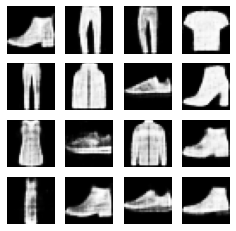

In [15]:
### display reconstructed figures ###
fig=plot(model(x_batch).detach().numpy().reshape(-1,28,28))

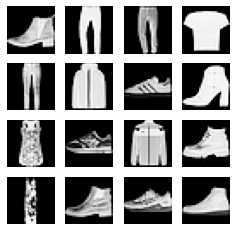

In [16]:
### display original figures ###
fig=plot(x_batch.numpy().reshape(-1,28,28))